<a href="https://colab.research.google.com/github/lapythie/ml/blob/master/ML_exam_random_forest_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Ссылка на папку экзамена](https://drive.google.com/drive/folders/1t3buUL5uddhLHjPHUo18sIlr1XxQ-141?usp=sharing), куда сохраняла всякие эмбеддинги, модели и пр.

In [ ]:
!pip install youtokentome
import youtokentome as yttm

     |████████████████████████████████| 1.7MB 2.8MB/s 


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import gensim

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, \
GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import *

from string import punctuation
punctuation += '«»—–…“”‘•'
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
tc = pd.read_csv('jigsaw-toxic-comment-train.csv')
val = pd.read_csv('validation.csv')

In [ ]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.min_rows", 100)
pd.set_option("display.max_colwidth", 100)

# *1) Анализ всех дополнительных колонок тональности (как проявляется тот или иной тип токсичности, как в данных это представлено, какие есть пограничные случаи) - 2.5 балла*

Анализ колонок

In [ ]:
for column in tc.columns:
    print(column, tc[column].nunique())
#     тут всё ожидаемо

id 223549
comment_text 223549
toxic 2
severe_toxic 2
obscene 2
threat 2
insult 2
identity_hate 2


In [ ]:
tc.describe()
# по строчке mean: среди токсичных
# больше всего обсценных комментариев и оскорблений
# реже всего попадаются угрозы

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000
mean,0.095657,0.008777,0.054306,0.003082,0.050566,0.009470
std,0.294121,0.093272,0.226621,0.055431,0.219110,0.096852
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


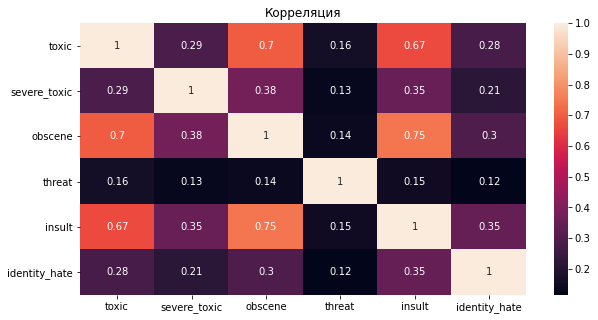

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=tc.corr(), 
            annot=True, ax=ax)
plt.title("Корреляция")
plt.show()

# как мы уже заметили,
# с токсичностью больше всего коррелируют оскорбления и мат

# ещё оскорбления и мат немного коррелируют с severe_toxic

In [ ]:
for column in tc.columns[2:]:
    print(tc[column].value_counts())
    print('============')

0    202165
1     21384
Name: toxic, dtype: int64
0    221587
1      1962
Name: severe_toxic, dtype: int64
0    211409
1     12140
Name: obscene, dtype: int64
0    222860
1       689
Name: threat, dtype: int64
0    212245
1     11304
Name: insult, dtype: int64
0    221432
1      2117
Name: identity_hate, dtype: int64


In [ ]:
tc.groupby(['toxic', 'insult']).agg(['nunique'])

id comment_text severe_toxic obscene  threat identity_hate
             nunique      nunique      nunique nunique nunique       nunique
toxic insult                                                                
0     0       201547       201547            1       2       2             2
      1          618          618            1       2       2             2
1     0        10698        10698            2       2       2             2
      1        10686        10686            2       2       2             2

In [ ]:
tc.groupby(['toxic', 'obscene']).agg(['nunique'])

id comment_text severe_toxic  threat  insult identity_hate
              nunique      nunique      nunique nunique nunique       nunique
toxic obscene                                                                
0     0        201577       201577            1       2       2             2
      1           588          588            1       2       2             2
1     0          9832         9832            2       2       2             2
      1         11552        11552            2       2       2             2

In [ ]:
tc.groupby(['insult', 'obscene']).agg(['nunique'])

id comment_text   toxic severe_toxic  threat identity_hate
               nunique      nunique nunique      nunique nunique       nunique
insult obscene                                                                
0      0        208989       208989       2            2       2             2
       1          3256         3256       2            2       2             2
1      0          2420         2420       2            2       2             2
       1          8884         8884       2            2       2             2

In [ ]:
#токсичные, но не относятся ни к одному из подклассов
tc[(tc['obscene']==0) &
  (tc['threat']==0) &
  (tc['insult']==0) &
  (tc['identity_hate']==0) &
  (tc['toxic']==1)].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
12,0005c987bdfc9d4b,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...",1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming back! Tosser.",1,0,0,0,0,0
44,001956c382006abd,"I'm Sorry \n\nI'm sorry I screwed around with someones talk page. It was very bad to do. I know how having the templates on their talk page helps you assert your dominance over them. I know I should bow down to the almighty administrators. But then again, I'm going to go play outside....with your mom. 76.122.79.82",1,0,0,0,0,0
59,002264ea4d5f2887,"Why can't you believe how fat Artie is? Did you see him on his recent appearence on the Tonight Show with Jay Leno? He looks absolutely AWFUL! If I had to put money on it, I'd say that Artie Lange is a can't miss candidate for the 2007 Dead pool! \n\n \nKindly keep your malicious fingers off of my above comment, . Everytime you remove it, I will repost it!!!",1,0,0,0,0,0
151,005f59485fcddeb0,"""\n\nSORRY PUCK BUT NO ONE EVER SAID DICK WAS NUMBER ONE!! But he is clearly listed as being """"second only to Batman"""" and a """"master detective and martial artist"""" and been trained in all the mentioned combat discplines. No need to mention in skills/abilities about the battles he's lost and won because thats not what an encylopia is supposed to do. \n\nAlso, what your problem is your going by...",1,0,0,0,0,0


In [ ]:
obscene = tc[
        (tc['obscene']==1) &
        (tc['threat']==0) &
        (tc['insult']==0) &
        (tc['identity_hate']==0)]
obscene_tokens = []
for comment in obscene['comment_text'].values:
    for token in comment.split():
        obscene_tokens.append(token)
d = Counter(obscene_tokens)

In [ ]:
# кроме стоп-слов в топ попали некоторые
# самые распространенные токсичные ругательства
# почти все они написаны капсом, что неудивительно
# капс коррелирует с токсичностью, как мы увидим позже
d.most_common(20)

[('the', 3904),
 ('to', 2987),
 ('I', 2753),
 ('a', 2675),
 ('and', 2520),
 ('you', 2477),
 ('is', 1931),
 ('of', 1869),
 ('FUCK', 1519),
 ('that', 1400),
 ('fuck', 1299),
 ('THE', 1228),
 ('DICKS', 1213),
 ('in', 1152),
 ('it', 1055),
 ('SHIT', 1030),
 ('YOU', 991),
 ('for', 959),
 ('have', 937),
 ('your', 909)]

In [ ]:
sample = tc[tc['toxic']==1][
    (
        (tc['obscene']==1) &
        (tc['threat']==0) &
        (tc['insult']==0) &
        (tc['identity_hate']==0)
    )|(
        (tc['obscene']==0) &
        (tc['threat']==1) &
        (tc['insult']==0) &
        (tc['identity_hate']==0)
    )|(
        (tc['obscene']==0) &
        (tc['threat']==0) &
        (tc['insult']==1) &
        (tc['identity_hate']==0)
    )|(
        (tc['obscene']==0) &
        (tc['threat']==0) &
        (tc['insult']==0) &
        (tc['identity_hate']==1)
    )
]


c:\users\ира\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## YOUTOKENTOME (не для оценивания, просто потом я его пыталась использовать для поиска признаков, которые могут обобщаться на многоязычные данные)

In [ ]:
%%time
#with lower()

train_data_path = 'train_data.txt'
model_path = 'consistent.model'
tc = pd.read_csv('jigsaw-toxic-comment-train.csv')

with open(train_data_path, 'w', encoding='utf-8') as fout:
    for comment in tc['comment_text'].values:
            print(comment.lower(), file=fout)

test_text = 'YOU FREAKING FUCKING BASTARD you freaking fucking bastard' 
yttm.BPE.train(data=train_data_path, 
               vocab_size=5000, model=model_path)
bpe = yttm.BPE(model=model_path)
print(bpe.encode([test_text], 
                 output_type=yttm.OutputType.ID))
print(bpe.encode([test_text], 
                 output_type=yttm.OutputType.SUBWORD))

In [ ]:
# %%time
def bpe_text(text, model=bpe):
    text = text.lower()
    text = ' '.join(model.encode([text], output_type=yttm.OutputType.SUBWORD)[0])
    return text
# много ниже для пары обобщающихся признаков использовала эту колонку
tc['bpe_consistent'] = tc['comment_text'].apply(bpe_text)
val['bpe_consistent'] = val['comment_text'].apply(bpe_text)

# 5) Поиск признаков, которые могут обобщаться на многоязычные данные (минимум 10 признаков рассмотрено, обучать можно любую модель, оценивать нужно на validation.csv)  - 3 балла

Поиск признаков на основе кода Сергея:

In [ ]:
import re 
import itertools
from string import punctuation
from collections import Counter

# У Сергея:
# делаем минимум нормализации т.к. хотим учитывать как можно больше признаков
# def soft_normalize(text):
#   text = re.sub("\n|\t|\s\"", " ", text)
#   return text

# У меня:
# нормализацию вообще делать не будем, посчитаем пробелообразные

# Эти две функции не нашли ничего на валидации
# def newline_count(text):
#     matches = re.findall('\n', text)
#     return len(matches)
# def tab_count(text):
#     matches = re.findall('\t', text)
#     return len(matches)

def space_count(text):
    matches = re.findall('\s', text)
    return len(matches)

def you_count (text):
    '''Только для трейна'''
    matches = re.findall('you', text.lower())
    return len(matches)

# У Сергея
# def has_link(text):
#   return int(re.search("https?://[^ ]+", text) is not None)

# У меня
def has_ip(text):
    rex = ["[0-9]+\.[0-9]+\.[0-9]+\.[0-9]+", 
           "[a-z0-9]+:[a-z0-9]+:[a-z0-9]+:[a-z0-9]+"]
    return int((re.search(rex[0], text) or
                re.search(rex[1], text)) is not None)

# У Сергея
# def longest_word(text):
#   tokens = tokenize(text)
#   length = 0
#   for t in tokens:
#     if len(t) > length:
#       length = len(t)
#   return length

# У меня
def longest_bpe(bpe_text):
    tokens = bpe_text.split()
    length = 0
    for t in tokens:
#         без спец.символа для пробела
#         это кстати не андерскор
        if len(t.strip('▁')) > length:
            length = len(t.strip('▁'))
    return length

# ещё придумала:

def ratio(func, text, if_split=False):
    if if_split:
        total = len(text.split())
    else:
        total = len(text)
    count = func(text)
    if count:
        return count/total
    else:
        return 0

def unique_bpe_count(bpe_text):
    tokens = bpe_text.split()
    return len(set(tokens))

def repeats_count(bpe_text):
    d = Counter()
    d = Counter(bpe_text.split())
    rex = None
    for bpe, _ in d.most_common():
        if len(bpe.strip('▁')) > 2:
            rex = bpe
            matches = re.findall(rex, bpe_text)
            return len(matches)
    if rex == None:
        return 0

In [ ]:
# Тут всё просто взяла у Сергея

def tokenize(text):
  text = re.sub(f"[{punctuation}]", " ", text)
  text = re.sub("\s+", " ", text)
  return text.split()

def sentenize(text):
  sents = re.split("[\n.!?]( |$)", text)
  return [s for s in sents if len(s) > 0 and s != " "]

def sents_count(text):
  return len(sentenize(text))

def mean_token_length(text):
  length = 0
  tokens = tokenize(text)
  if len(tokens) == 0:
    return 0
  for token in tokens:
    length += len(token)
  return length/len(tokens)

def caps_ratio(text):
  total = len(text)
  caps = 0
  for letter in text:
    if letter not in punctuation and letter != " ":
      if letter.lower() != letter:
        caps += 1
  return caps/total

def nonalpha_ratio(text):
  total = len(text)
  nonalpha = 0
  sents = sentenize(text)
  for sent in sents:
    for letter in text:
      if letter in punctuation:
        nonalpha += 1
  return nonalpha/total

def numeric_ratio(text):
  total = len(text)
  numeric = 0
  for letter in text:
    if letter.isnumeric():
      numeric += 1
  return numeric/total

def max_sent_complexity(text):
  compl = 0
  sents = sentenize(text)
  for s in sents:
    matches = re.findall("[,;\:\-()]+", s)
    if len(matches) > compl:
      compl = len(matches)
  return compl

def rage_punctuation_length(text):
  length = 0
  matches = re.findall("[?!.]+", text)
  for m in matches:
    if len(m) > length:
      length = len(m)
  return length

def longest_same_char(text):
  length = 0
  curr_length = 1
  for i in range(1,len(text)):
    if text[i] == text[i-1]:
      curr_length += 1
    else:
      if curr_length > length:
        length = curr_length
      curr_length = 1
  if curr_length > length:
    return curr_length
  return length

In [ ]:
%%time
# 8 признаков Сергея
tc['text_mean_tokens_length'] = tc['comment_text'].apply(mean_token_length)
tc['text_sents_count'] = tc['comment_text'].apply(sents_count)
tc['text_caps_ratio'] = tc['comment_text'].apply(caps_ratio)
tc['text_nonalpha_ratio'] = tc['comment_text'].apply(nonalpha_ratio)
tc['text_numeric_ratio'] = tc['comment_text'].apply(numeric_ratio)
# tc['text_has_link'] = tc['comment_text'].apply(has_link)
# tc['text_longest_word'] = tc['comment_text'].apply(longest_word)
tc['text_complexity'] = tc['comment_text'].apply(max_sent_complexity)
tc['text_rage_punctuation_length'] = tc['comment_text'].apply(rage_punctuation_length)
tc['text_longest_same_char'] = tc['comment_text'].apply(longest_same_char)

Wall time: 2min 52s


In [ ]:
%%time
# 8 признаков Сергея
val['text_mean_tokens_length'] = val['comment_text'].apply(mean_token_length)
val['text_sents_count'] = val['comment_text'].apply(sents_count)
val['text_caps_ratio'] = val['comment_text'].apply(caps_ratio)
val['text_nonalpha_ratio'] = val['comment_text'].apply(nonalpha_ratio)
val['text_numeric_ratio'] = val['comment_text'].apply(numeric_ratio)
# val['text_has_link'] = val['comment_text'].apply(has_link)
# val['text_longest_word'] = val['comment_text'].apply(longest_word)
val['text_complexity'] = val['comment_text'].apply(max_sent_complexity)
val['text_rage_punctuation_length'] = val['comment_text'].apply(rage_punctuation_length)
val['text_longest_same_char'] = val['comment_text'].apply(longest_same_char)

Wall time: 4.15 s


In [ ]:
%%time
# 12 моих признаков

# (первые четыре признака были рассмотрены, но отвалились, 
# так как в валидационной выборке не нашлось пробелообразных кроме \s)

# tc['newline_count'] = tc['comment_text']. apply(lambda s: newline_count(s))
# tc['newline_ratio'] = tc['comment_text']. apply(lambda s: ratio(newline_count, s))
# tc['tab_count'] = tc['comment_text']. apply(lambda s: tab_count(s))
# tc['tab_ratio'] = tc['comment_text']. apply(lambda s: ratio(tab_count, s))

# только для трейна
# tc['you_ratio'] = tc['comment_text']. apply(lambda s: ratio(you_count, s, if_split=True))

tc['space_count'] = tc['comment_text']. apply(lambda s: space_count(s))
tc['space_ratio'] = tc['comment_text']. apply(lambda s: ratio(space_count, s))

tc['has_ip'] = tc['comment_text']. apply(lambda s: has_ip(s))

tc['longest_bpe'] = tc['bpe_consistent']. apply(lambda s: longest_bpe(s))
tc['unique_bpe'] = tc['bpe_consistent'].apply(lambda s: unique_bpe_count(s))
tc['unique_bpe_ratio'] = tc['bpe_consistent'].apply(lambda s: ratio(unique_bpe_count, s, if_split=True))

tc['repeats_count'] = tc['bpe_consistent']. apply(lambda s: repeats_count(s))
tc['repeats_ratio'] = tc['bpe_consistent']. apply(lambda s: ratio(repeats_count, s, if_split=True))

Wall time: 35.8 s


In [ ]:
tc.groupby(['toxic']).mean()
# судя по средним, предполагаю, что всё, что с ratio, малоинформативно

,severe_toxic,obscene,threat,insult,identity_hate,space_count,space_ratio,has_ip,longest_bpe,repeats_count,...,unique_bpe,unique_bpe_ratio,text_mean_tokens_length,text_sents_count,text_caps_ratio,text_nonalpha_ratio,text_numeric_ratio,text_complexity,text_rage_punctuation_length,text_longest_same_char
toxic,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.002909,0.000173,0.003057,0.000603,71.694185,0.177423,0.044859,6.606836,5.511503,...,80.482527,0.740973,4.487762,4.908293,0.045593,0.239584,0.011150,2.615008,1.271521,2.788213
1,0.091751,0.540217,0.030584,0.499719,0.093294,50.899598,0.184295,0.064254,5.508651,7.095024,...,50.986626,0.784000,4.472755,4.134774,0.112576,0.242793,0.009353,1.569351,2.470165,4.699074


# 2) Бейзлайн модель, которая работает на отложенной выборке (train_test_split) и validation.csv (различие в точности может быть большим, но главное попробовать любыми способами его уменьшить и зафиксировать эксперименты) - 3 балла


In [ ]:
# код из домашки по overfitting validation

def gs_func(clf, parameter_grid, cv, scoring='roc_auc'):
    grid_search = GridSearchCV(clf, parameter_grid, scoring, cv=cv)
    grid_search.fit(X_train, y_train)

    predicted_probs = grid_search.predict_proba(X_test)
    roc_auc_test = roc_auc_score(y_test, predicted_probs[:, 1])

    print('Best parameters: {}'.format(grid_search.best_params_))  
    print('ROC AUC score of the best_estimator: {}\
    '.format(grid_search.best_score_))
    print('ROC AUC score на тесте: {}\
    '.format(roc_auc_test))
    
    return grid_search

def fold(nfolds=10, random_st=0, nrepeats=10, if_shuffle=True):
    folds = KFold(n_splits=nfolds, shuffle=if_shuffle, 
                  random_state=random_st)
    stratified_folds = StratifiedKFold(n_splits=nfolds, 
                                       shuffle=if_shuffle, 
                                       random_state=random_st)
    repeated_folds = RepeatedStratifiedKFold(
        n_splits=nfolds, n_repeats=nrepeats, random_state=random_st)
    return folds, stratified_folds, repeated_folds

In [ ]:
%%time
# 12 моих признаков

# (первые четыре признака были рассмотрены, но отвалились, 
# так как в валидационной выборке не нашлось пробелообразных кроме \s)
# val['newline_count'] = val['comment_text']. apply(lambda s: newline_count(s))
# val['newline_ratio'] = val['comment_text']. apply(lambda s: ratio(newline_count, s))
# val['tab_count'] = val['comment_text']. apply(lambda s: tab_count(s))
# val['tab_ratio'] = val['comment_text']. apply(lambda s: ratio(tab_count, s))

val['space_count'] = val['comment_text']. apply(lambda s: space_count(s))
val['space_ratio'] = val['comment_text']. apply(lambda s: ratio(space_count, s))

val['has_ip'] = val['comment_text']. apply(lambda s: has_ip(s))

val['repeats_count'] = val['bpe_consistent']. apply(lambda s: repeats_count(s))
val['repeats_ratio'] = val['bpe_consistent']. apply(lambda s: ratio(repeats_count, s, if_split=True))

val['longest_bpe'] = val['bpe_consistent']. apply(lambda s: longest_bpe(s))
val['unique_bpe'] = val['bpe_consistent'].apply(lambda s: unique_bpe_count(s))
val['unique_bpe_ratio'] = val['bpe_consistent'].apply(lambda s: ratio(unique_bpe_count, s, if_split=True))

Wall time: 3.23 s


In [ ]:
val.groupby(['toxic']).mean()

,id,space_count,space_ratio,has_ip,repeats_count,repeats_ratio,longest_bpe,unique_bpe,unique_bpe_ratio,text_mean_tokens_length,text_sents_count,text_caps_ratio,text_nonalpha_ratio,text_numeric_ratio,text_complexity,text_rage_punctuation_length,text_longest_same_char
toxic,,,,,,,,,,,,,,,,,
0,4010.520827,60.898080,0.164273,0.018464,6.376071,0.035328,4.126440,83.955096,0.489439,5.372874,4.708419,0.035149,0.152742,0.009301,2.803250,1.532201,3.216396
1,3938.840650,51.930081,0.166935,0.089431,8.873984,0.046077,4.082114,76.807317,0.515956,4.902702,3.694309,0.077272,0.142674,0.009559,2.345528,2.094309,3.564228


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    tc[tc.columns[9:]], tc['toxic'], 
    test_size=0.3, random_state=1
)
X_val = val[val.columns[5:]]
y_val = val['toxic']

In [ ]:
for matrix in (X_train, X_test, y_train, y_test):
    print(matrix.shape)

(156484, 16)
(67065, 16)
(156484,)
(67065,)


In [ ]:
repeated_folds = fold(nfolds=3)[2]

In [ ]:
%%time
parameter_grid = {'C' : [0.0001],
#     'C' : [x*0.0001 for x in [10, 100, 1000]], #or more
    'class_weight' : [None], 
    'fit_intercept' : [True], 
    # 'l1_ratio' : [x/10 for x in range (0,11)], #only elasticnet
    'max_iter' : [50],
    'penalty' : [
#                  'l1', 
                 'l2'], 
    'random_state' : [0],
    'solver' : ['liblinear'],
    'warm_start' : [False]}

lr_gs = gs_func(LogisticRegression(), parameter_grid, cv=repeated_folds)

Best parameters: {'C': 0.0001, 'class_weight': None, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'warm_start': False}
ROC AUC score of the best_estimator: 0.6967222842473263    
ROC AUC score на тесте: 0.6972690346653782    
Wall time: 51.7 s


In [ ]:
predicted_probs = lr_gs.predict_proba(X_val)
roc_auc_score(y_val, predicted_probs[:, 1])

0.5963613983259478

На тесте: 0.6972690346653782 

На валидации: 0.5963613983259478

Различие между отложенным тестом и валидацией:

In [ ]:
0.6972690346653782-0.5963613983259478

0.10090763633943034

**Можно подыскать бейзлайн получше**

In [ ]:
%%time
parameter_grid = {
    'class_weight':[{0: 0.9, 1: 0.1}], 
    'min_samples_leaf':[15], 'n_estimators':[100], 'random_state':[1], 'max_depth':[7]
#     , min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort='deprecated', ccp_alpha=0.0)
}
dtc_gs = gs_func(RandomForestClassifier(), parameter_grid, 
                 cv=repeated_folds)


Best parameters: {'class_weight': {0: 0.9, 1: 0.1}, 'max_depth': 7, 'min_samples_leaf': 15, 'n_estimators': 100, 'random_state': 1}
ROC AUC score of the best_estimator: 0.7668684329631117    
ROC AUC score на тесте: 0.7676569818136723    
Wall time: 8min 55s


In [ ]:
predicted_probs = rf_gs.predict_proba(X_val)
roc_auc_score(y_val, predicted_probs[:, 1])

0.6674470704086657

На тесте: 0.7676569818136723

На валидации: 0.6674470704086657

Различие между отложенным тестом и валидацией:

In [ ]:
0.7676569818136723-0.6674470704086657

0.10020991140500657

**Это будет бейзлайн.**

In [ ]:
for i in range(len(val.columns[5:])):
    print(val.columns[5:][i], '\t\t\t',
          dtc_gs.best_estimator_.feature_importances_[i])
# бейзлайновый рэндом форест обучился на капсах:

space_count 			 0.05683530627552082
space_ratio 			 0.040558268316005064
has_ip 			 0.0010302836679211029
repeats_count 			 0.0444257320942115
repeats_ratio 			 0.04155262607579755
longest_bpe 			 0.04285722980539224
unique_bpe 			 0.04528466636322581
unique_bpe_ratio 			 0.0559500692945904
text_mean_tokens_length 			 0.08001023737605277
text_sents_count 			 0.015977394993384592
text_caps_ratio 			 0.35293674691493343
text_nonalpha_ratio 			 0.06491552840675165
text_numeric_ratio 			 0.006437935696834319
text_complexity 			 0.09503347695752065
text_rage_punctuation_length 			 0.039209768630021145
text_longest_same_char 			 0.01698472913183691


Наверное, различие в метрике можно уменьшить гридсерчем

In [ ]:
%%time
parameter_grid = {
    'class_weight':[{0: x, 1: 1-x} for x in np.arange(0.89, 0.92, 0.01)], 
    'min_samples_leaf':[x for x in range(14, 17)], 
    'n_estimators':[x for x in range(90, 111, 10)], 'random_state':[1], 
    'max_depth':[x for x in range(6, 9)]
}
rf_gs = gs_func(RandomForestClassifier(), parameter_grid, 
                 cv=repeated_folds)
predicted_probs = rf_gs.predict_proba(X_val)
roc_auc_score(y_val, predicted_probs[:, 1])

Best parameters: {'class_weight': {0: 0.89, 1: 0.10999999999999999}, 'max_depth': 8, 'min_samples_leaf': 16, 'n_estimators': 110, 'random_state': 1}
ROC AUC score of the best_estimator: 0.7716035633094921    
ROC AUC score на тесте: 0.773291358426092    
Wall time: 13h 56min 42s


0.6787625343757131

In [ ]:
0.773291358426092-0.6787625343757131

0.09452882405037888

In [ ]:
# import pickle
# pkl_filename = "gs_rf_model.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(rf_gs, file)
# with open(pkl_filename, 'rb') as file:
#     pickle_model = pickle.load(file)

За 13 часов метрика на валидации подросла на сотую и на сотую уменьшилась разница между тестом и валидацией.

Это того не стоило...

In [ ]:
for i in range(len(val.columns[5:])):
    print(val.columns[5:][i], '\t\t\t',
          rf_gs.best_estimator_.feature_importances_[i])
# обучился опять на капсах

space_count 			 0.05263126412107628
space_ratio 			 0.047515319309836546
has_ip 			 0.001184664214577729
repeats_count 			 0.05062260004471807
repeats_ratio 			 0.04123461635714071
longest_bpe 			 0.04061674173947386
unique_bpe 			 0.04604011166134813
unique_bpe_ratio 			 0.05988724380970862
text_mean_tokens_length 			 0.08376249197856021
text_sents_count 			 0.016075744264198617
text_caps_ratio 			 0.3338000855789444
text_nonalpha_ratio 			 0.06838439549091871
text_numeric_ratio 			 0.008000900107749563
text_complexity 			 0.09195838529188433
text_rage_punctuation_length 			 0.04239631026267872
text_longest_same_char 			 0.01588912576718543


В ходе экспериментов рэндом форест частенько обучался на text_nonalpha_ratio, но на валидации это давало гораздо менее хороший результат. ROC AUC падала на 0.1 по сравнению с моделями, обучившимися на капсах.

# *3) Ансамбль из моделей в sklearn (ансамблевые модели типа randomforest не считаются). Нужно минимум 5 разных моделей - 2 балла*

Ансамбль из ансамблевых ансамблей (нет)

In [ ]:
%%time
# VotingClassifier 4
        
clf1 = LogisticRegression(C=0.0001, max_iter=50, penalty='l2',
                          solver='liblinear', 
                          random_state=0)
clf2 = RandomForestClassifier(n_estimators=100, random_state=0)
clf3 = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf4 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                           max_depth=1, random_state=0)
clf5 = AdaBoostClassifier(n_estimators=100, random_state=0)
clf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('etc', clf3),
                                  ('gbc', clf4), ('abc', clf5)],
                             voting='soft', weights=[1,2,2,1,1],
                             flatten_transform=True)
clf.fit(X_train, y_train)
predicted_probs = clf.predict_proba(X_val)
roc_auc_score(y_val, predicted_probs[:, 1])

Wall time: 3min 5s


0.6937737027296417

In [ ]:
predicted_probs = clf.predict_proba(X_test)
rocauc_test = roc_auc_score(y_test, predicted_probs[:, 1])
predicted_probs = clf.predict_proba(X_val)
rocauc_val = roc_auc_score(y_val, predicted_probs[:, 1])
print ('Разница между тестовым и валидационным сетом:', rocauc_test-rocauc_val)

Разница между тестовым и валидационным сетом: 0.09233269078977224


Незначительные улучшения в разнице, чуть более значительные улучшения по сравнению с бейзлайном (бейзлайн - 0.678.)

# *4) Использование предобученной модели из huggingface для обучения классификатора с оценкой на validation.csv - 3 балла*

Как-то в нисе мы планировали использовать берт-как-сервис. Использовала его (в колабе) для получения эмбеддингов. В колабе он заводится вот как-то так, странно.

Check out [this issue](https://github.com/hanxiao/bert-as-service/issues/380) and "*make sure Colab is using Tensorflow 1.x, because bert-serving-start doesn't currently work with TF 2.1 and nohup hides the output of the command failing*"

In [ ]:
%tensorflow_version 1.x
# import tensorflow as tf
# print (tf.__version__)

TensorFlow 1.x selected.


In [ ]:
%%capture
!pip install -U bert-serving-server[http]
!pip install bert-serving-client  # client, independent of `bert-serving-server`

In [ ]:
%%capture
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
!unzip /content/multi_cased_L-12_H-768_A-12.zip

In [ ]:
# тут я увеличила максимальный размер последовательности
# но это не помогло и он берт клиент помирал
# пришлось заэмбеддить только последние пять слов коммента
!nohup bert-serving-start -max_seq_len=512 -model_dir=./multi_cased_L-12_H-768_A-12 > out.file 2>&1 &

In [ ]:
from bert_serving.client import BertClient
bc = BertClient()

In [ ]:
bc.status
# всё в порядке

{'client_version': '1.10.0',
 'identity': b'a22e2c2e-ada9-4504-92b5-4b30f0a5638d',
 'num_pending_request': 0,
 'num_request': 9,
 'output_fmt': 'ndarray',
 'pending_request': set(),
 'port': 5555,
 'port_out': 5556,
 'server_ip': 'localhost',
 'timeout': -1}

In [ ]:
encoded_test = bc.encode(['here we go again and'])
# потом используем размер получающихся эмбеддингов

In [ ]:
tc = pd.read_csv('jigsaw-toxic-comment-train.csv')
val = pd.read_csv('validation.csv')
tc = tc.sample(frac=0.05, random_state=0)

In [ ]:
tc.shape
# размер сэмпла, на котором будем обучаться, чуть больше размера валидационного сета

(11177, 8)

In [ ]:
train_matrix = np.zeros((len(tc),
                   len(encoded_test[0])))
train_matrix.shape

(11177, 768)

In [ ]:
def leave_last5(text):
    split_text = text.split()
    if len(split_text) > 4:
        return ' '.join(split_text[-5:])
    else:
        return text
# колонка с последними пятью токенами
tc['last5'] = tc['comment_text'].apply(leave_last5)
val['last5'] = val['comment_text'].apply(leave_last5)

In [ ]:
%%time
final_batch_size = len(tc)%64
seqs = tc['last5'].to_list()
outfile = 'train_matrix'
for i, seq in enumerate(seqs):
    if not ((i)+1)%64:
        train_matrix[(i-63):(i+1)] = bc.encode(seqs[(i-63):(i+1)])

# проверяла на связи ли берт
    # if not ((i)+1)%512:
    #     print (i, train_matrix[i-2][0:5])
    #     print('BERT_SERVER_STATUS', bc.server_status)
    #     print('BERT_CLIENT_STATUS', bc.status)

train_matrix[-(final_batch_size):] = bc.encode(seqs[-(final_batch_size):])

np.save(outfile, train_matrix)

In [ ]:
# from google.colab import files
# files.download('train_matrix.npy') 

Вадидацию тоже заэмбеддим

In [ ]:
val_matrix = np.zeros((len(val),
                   len(encoded_test[0])))
print(val_matrix.shape)

final_batch_size = len(val)%64

(8000, 768)


In [ ]:
seqs = val['last5'].to_list()
outfile = 'val_matrix'
for i, seq in enumerate(seqs):
    if not ((i)+1)%64:
        val_matrix[(i-63):(i+1)] = bc.encode(seqs[(i-63):(i+1)])

    if not ((i)+1)%1024:
        print (i, val_matrix[i-2][0:5])
        print('BERT_SERVER_STATUS', bc.server_status)
        print('BERT_CLIENT_STATUS', bc.status)

val_matrix[-(final_batch_size):] = bc.encode(seqs[-(final_batch_size):])

np.save(outfile, val_matrix)

Эмбеддинги гигантские, может лучше их ужать...

In [ ]:
train_data = np.load('/content/drive/My Drive/Colab Notebooks/homework_ml_m1/ML_exam/train_matrix.npy')

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(50)
transformed_train = svd.fit_transform(train_data)

In [ ]:
transformed_train.shape

(11177, 50)

In [ ]:
val_data = np.load('/content/drive/My Drive/Colab Notebooks/homework_ml_m1/ML_exam/val_matrix.npy')
transformed_val = svd.fit_transform(val_data)
transformed_val.shape

(8000, 50)

Обучим бейзлайновую модель на этих ужатых эмбеддингах и наших признаках

In [ ]:
# ранее сохраненные колонки с фичами
X_train = pd.read_csv('X_train_features.csv').sample(frac=0.05, random_state=0)
y_train = pd.read_csv('y_train_features.csv').sample(frac=0.05, random_state=0)
X_val = pd.read_csv('X_val_features.csv')
y_val = pd.read_csv('y_val_features.csv')

In [ ]:
# как-то криво сохранила, поэтому
X_train.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_val.drop(columns=['Unnamed: 0'], inplace=True)
y_val.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
# np.concatenate((a, b.T), axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    np.concatenate((X_train, transformed_train), axis=1),
    y_train, 
    test_size=0.3, random_state=1
)

X_val = np.concatenate((X_val, transformed_val), axis=1)

In [ ]:
y_train.shape

(7823, 1)

In [ ]:
repeated_folds = fold(nfolds=3)[2]

In [ ]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
y_val = y_val.values.ravel()

In [ ]:
%%time
parameter_grid = {
    'class_weight':[{0: 0.9, 1: 0.1}], 
    'min_samples_leaf':[15], 'n_estimators':[100], 'random_state':[1], 'max_depth':[7]
#     , min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort='deprecated', ccp_alpha=0.0)
}
dtc_gs = gs_func(RandomForestClassifier(), parameter_grid, 
                 cv=repeated_folds)


Best parameters: {'class_weight': {0: 0.9, 1: 0.1}, 'max_depth': 7, 'min_samples_leaf': 15, 'n_estimators': 100, 'random_state': 1}
ROC AUC score of the best_estimator: 0.8178594422983588    
ROC AUC score на тесте: 0.8276202337314031    
CPU times: user 1min 5s, sys: 42.1 ms, total: 1min 5s
Wall time: 1min 5s


In [ ]:
predicted_probs = dtc_gs.predict_proba(X_val)
roc_auc_score(y_val, predicted_probs[:, 1])
# было 0.6674470704086657

0.6232230908719721

БЫЛО:
На валидации: 0.6674470704086657

Резюмируем: на валидации качество упало! Хоть и выросло на тесте

In [ ]:
for i in range(0,66):
    print(i, '\t\t\t',
          dtc_gs.best_estimator_.feature_importances_[i])
# обучился на каком-то (номер 19) измерении ужатого вектора

# *6) Вместо сабмитов: Выкладывание своего решения в общем чате (полное или частичное решение любой ячейки из строчек 3,4,5 ) - 1 баллов за выкладывание и 0.5 балл за каждое использование вашего решения*

\#ml_project_sharing

[Токенизация с помощью библиотеки tokenizers](https://colab.research.google.com/drive/1dP45KBNEaMrxFGiXp7CCd7Ks9rhE0trH?usp=sharing)

# Trash (не для оценивания, просто всякие попытки)

In [ ]:
# !pip install iso-language-codes
# !pip install alphabet


In [ ]:
# import alphabet
# import random
# import json
# import iso_language_codes

## Поиск многоязычных данных в трейне

In [ ]:
with open('lang_column_2.json') as fr:
    lang_column = json.load(fr)
assert len(lang_column) == len(tc)
tc['lang'] = lang_column

lang_names = sorted({'data', 'ja', 'hi', 'jazh-CN', 'te', 'si', 'hine', 'am', 'ru', 'bg', 'en', 'de', 'el', 'kn', 'arsd', 'my', 'ko', 'ka', 'mn', 'ku', 'lo', 'gu', 'zh-CN', 'iw', 'yi', 'cy', 'it', 'fa', 'vi', 'ps', 'sr', 'ta', 'zh-CNja', 'sd', 'pl', 'hy', 'tg', 'pa', 'ro', 'ur', 'th', 'ar', 'or', 'km', 'bn', 'ml', })
target_langs = (set(lang_names)&
                   set(tc[tc['lang']!='en']['lang'].unique()))
print('Unique values in lang column:',
      len(tc[tc['lang']!='en']['lang'].unique()))
print('Values we are going to focus on:', len(target_langs))

Unique values in lang column: 350
Values we are going to focus on: 40


In [ ]:
len(lang_names)

46

In [ ]:
for i, l in enumerate(target_langs):
    try:
        print(i, l, iso_language_codes.language(l)['Name'], 
             '\t|\t Entries:', len(tc[tc['lang']==l]))
    except:
        print (i, l, 'no name',
             '| Entries:', len(tc[tc['lang']==l]))

0 gu Gujarati 	|	 Entries: 25
1 yi Yiddish 	|	 Entries: 3
2 am Amharic 	|	 Entries: 1
3 ku Kurdish 	|	 Entries: 7
4 ps Pashto 	|	 Entries: 2
5 it Italian 	|	 Entries: 51
6 zh-CN no name | Entries: 55
7 sr Serbian 	|	 Entries: 7
8 ka Georgian 	|	 Entries: 17
9 ja Japanese 	|	 Entries: 52
10 el Greek 	|	 Entries: 89
11 tg Tajik 	|	 Entries: 1
12 ro Romanian 	|	 Entries: 47
13 bn Bangla 	|	 Entries: 34
14 th Thai 	|	 Entries: 7
15 kn Kannada 	|	 Entries: 7
16 arsd no name | Entries: 1
17 ur Urdu 	|	 Entries: 7
18 iw no name | Entries: 24
19 my Burmese 	|	 Entries: 3
20 sd Sindhi 	|	 Entries: 1
21 km Khmer 	|	 Entries: 1
22 te Telugu 	|	 Entries: 10
23 hi Hindi 	|	 Entries: 122
24 si Sinhala 	|	 Entries: 2
25 data no name | Entries: 1
26 cy Welsh 	|	 Entries: 11
27 fa Persian 	|	 Entries: 69
28 ko Korean 	|	 Entries: 29
29 or Odia 	|	 Entries: 1
30 ar Arabic 	|	 Entries: 133
31 vi Vietnamese 	|	 Entries: 56
32 ta Tamil 	|	 Entries: 22
33 ml Malayalam 	|	 Entries: 19
34 bg Bulgarian 	|	 Ent

## *3) Сравнение нескольких ансамблевых моделей из sklearn (из sklearn.ensemble) на любой валидации - 1 балл*

In [ ]:
%%time
# GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                           max_depth=1, random_state=0)
clf.fit(X_train, y_train)

predicted_probs = clf.predict_proba(X_val)
roc_auc_score(y_val, predicted_probs[:, 1])

Wall time: 23.5 s


0.527164919359681

In [ ]:
%%time
# ExtraTreesClassifier пока что лидер
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
predicted_probs = clf.predict_proba(X_val)
roc_auc_score(y_val, predicted_probs[:, 1])

Wall time: 39.9 s


0.6681662283387974

In [ ]:
%%time
# AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
predicted_probs = clf.predict_proba(X_val)
roc_auc_score(y_val, predicted_probs[:, 1])

Wall time: 27.1 s


0.6120966482929231

In [ ]:
%%time
# BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
clf = BaggingClassifier(KNeighborsClassifier(), random_state=0,
                        max_samples=0.5, max_features=0.5)
clf.fit(X_train, y_train)
predicted_probs = clf.predict_proba(X_val)
roc_auc_score(y_val, predicted_probs[:, 1])

Wall time: 1min 29s


0.593363656014699

In [ ]:
%%time
# StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
estimators = [('rf', RandomForestClassifier(n_estimators=100,
                                            random_state=0)), 
              ('svr', make_pipeline(StandardScaler(), 
                                    LinearSVC(random_state=0)))]
clf = StackingClassifier(estimators=estimators,
                         final_estimator=LogisticRegression())
clf.fit(X_train, y_train)
predicted_probs = clf.predict_proba(X_val)
roc_auc_score(y_val, predicted_probs[:, 1])

c:\users\ира\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ира\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ира\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ира\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ира\appdata\local\programs\python\python37\lib\site-packages\sk

Wall time: 11min 29s


0.6539062818988604

In [ ]:
%%time
# VotingClassifier 1
clf1 = LogisticRegression(multi_class='multinomial', max_iter=600, 
                          random_state=0)
clf2 = RandomForestClassifier(n_estimators=100, random_state=0)
clf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2)], 
                             voting='soft', weights=[1,2,2],
                             flatten_transform=True)
clf.fit(X_train, y_train)
predicted_probs = clf.predict_proba(X_val)
roc_auc_score(y_val, predicted_probs[:, 1])

c:\users\ира\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Wall time: 1min 32s
Parser   : 454 ms


0.6636855567964837

In [ ]:
%%time
# VotingClassifier 2
clf1 = LogisticRegression(multi_class='multinomial', max_iter=600, 
                          random_state=0)
clf2 = RandomForestClassifier(n_estimators=100, random_state=0)
clf3 = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('etc', clf3)],
                             voting='soft', weights=[1,2,2],
                             flatten_transform=True)
clf.fit(X_train, y_train)
predicted_probs = clf.predict_proba(X_val)
roc_auc_score(y_val, predicted_probs[:, 1])

c:\users\ира\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Wall time: 2min 55s


0.6833867132615196

In [ ]:
%%time
# VotingClassifier 3
        
clf1 = LogisticRegression(C=0.0001, max_iter=50, penalty='l2',
                          solver='liblinear', 
                          random_state=0)
clf2 = RandomForestClassifier(n_estimators=100, random_state=0)
clf3 = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('etc', clf3)],
                             voting='soft', weights=[1,2,2],
                             flatten_transform=True)
clf.fit(X_train, y_train)
predicted_probs = clf.predict_proba(X_val)
roc_auc_score(y_val, predicted_probs[:, 1])

Wall time: 2min 2s


0.6931088254014003

In [ ]:
# на тесте
predicted_probs = clf.predict_proba(X_test)
roc_auc_score(y_test, predicted_probs[:, 1])

0.7857637480169044

In [ ]:
0.7857637480169044-0.6931088254014003

0.09265492261550412

Различие ещё чучуть уменьшилось (на две сотых).

Вроде бы из тех ансамблевых моделей, которые не ансамбли, лидером так и остался ExtraTreesClassifier.

## *4) Нейронная модель в керасе (Embedding слой +  Flatten + Dense) - 1 балл*#

Vanilla NN на фасттекстовых эмбеддингах (как в домашке) отработала плохо на валидации (как будет видно ниже). Этого следовало ожидать, потому что, ну, валидационный сет неанглоязычный. Не знаю, на что я вообще рассчитывала.

Поэтому **обучим её всё-таки в итоге на признаках, которые по нашей задумке должны обобщаться на валидацию**.

Большая часть кода здесь из домашки по nn_intro. Только я ещё её не сдала...

In [ ]:
# переносила признаки в колаб
# tc[tc.columns[9:]].to_csv('X_train_features.csv')
# tc['toxic'].to_csv('y_train_features.csv')
# val[val.columns[5:]].to_csv('X_val_features.csv')
# val['toxic'].to_csv('y_val_features.csv')

In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/homework_ml_m1/ML_exam/jigsaw-toxic-comment-train.csv.zip'
!unzip '/content/drive/My Drive/Colab Notebooks/homework_ml_m1/ML_exam/validation.csv.zip'

Archive:  /content/drive/My Drive/Colab Notebooks/homework_ml_m1/ML_exam/jigsaw-toxic-comment-train.csv.zip
  inflating: jigsaw-toxic-comment-train.csv  
Archive:  /content/drive/My Drive/Colab Notebooks/homework_ml_m1/ML_exam/validation.csv.zip
  inflating: validation.csv          
Archive:  /content/drive/My Drive/Colab Notebooks/homework_ml_m1/ML_exam/Не особо пригодилось/test.csv.zip
  inflating: test.csv                


In [ ]:
tc = pd.read_csv('jigsaw-toxic-comment-train-processed-seqlen128.csv')
val = pd.read_csv('validation-processed-seqlen128.csv')

In [ ]:
vocab = Counter()
for text in tc.comment_text:
    vocab.update(preprocess(text))
len(vocab)

374016

In [ ]:
filtered_vocab = set()
for word in vocab:
    if vocab[word] > 50:
        filtered_vocab.add(word)
len(filtered_vocab)

11655

In [ ]:
word2id = {'UNK':1, 'PAD':0}
for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [ ]:
X=[]
for text in tc.comment_text:
    tokens = preprocess(text)
    ids = [word2id.get(token, word2id['UNK']) for token in tokens]
    X.append(ids)
MAX_LEN = max(len(x) for x in X)
MAX_LEN

2321

In [ ]:
X_val=[]
for text in val.comment_text:
    tokens = preprocess(text)
    ids = [word2id.get(token, word2id['UNK']) for token in tokens]
    X_val.append(ids)
MAX_LEN_VAL = max(len(x) for x in X_val)
MAX_LEN_VAL

211

In [ ]:
# длина 2321 это уж слишком, возьмем поменьше
MAX_LEN = 512

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X.shape

(223549, 512)

In [ ]:
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=MAX_LEN)
X_val.shape

(8000, 512)

In [ ]:
y = tc.toxic.values
# это лишнее
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42)
# оценимся сразу на валидации
X_train, y_train = X, tc.toxic.values

Я правда не знаю, зачем тут фасттекст, но это было сделано

In [ ]:
texts = tc.comment_text.apply(preprocess).tolist()

In [ ]:
%%time
ft = gensim.models.FastText(texts, size=200, iter=2)

CPU times: user 6min 54s, sys: 2.2 s, total: 6min 56s
Wall time: 3min 44s


In [ ]:
ft.most_similar('xcfghjedfgbnjk')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('dxgfcghjmb,k.fmjdhasgthujgfydszvfgyuihugytfdrtyghijkhgfgnhjmutrdesedfgyuiytrdgfnoiuytihugyftdrtftfkyghyduysgcbyuhjhhhhhhhhhhgbhjuggufyafgvwaygeufvbt6yawstdygujimaqzwerstdgyuhnjmkrlgfthyjuidfcgvhjbnkmlfdgrchujwazsexdrcftgvyhunjwazesrdtgfybhujimkszxdgfvhjnmkl,dvgfhjklxdcfgvhjnkm,ldsfghjkwsxedrctfvgybhujnmk,sdlfghjklsxdcfvghjnkml,swdyghukbjnkmlgf,uhjfvjnfvjishgiulgbiuskjhgisuhuihgiuhgoiuhsihiusghiusghisuhsiuhgiushiulhisughiushijkhbnkjfghsdiurgb',
  0.9334354400634766),
 ('y/n', 0.9158844351768494),
 ('69.3.8.74', 0.9143531322479248),
 ('৳', 0.9140912294387817),
 ('ž', 0.9137455821037292),
 ('ź', 0.9131422638893127),
 ('спасибо', 0.9120252728462219),
 ('członków', 0.9119718670845032),
 ('ć', 0.9111043214797974),
 ('nó', 0.9092568159103394)]

In [ ]:
weights = np.zeros((len(word2id), 200))
for word, i in word2id.items():
    if word == 'PAD':
        continue
    if word == 'UNK':
        weights[i] = ft['cmurrvntbcmirbycw']
    
    try:
        weights[i] = ft[word]
    except KeyError:
        weights[i] = ft['xcfghjedfgbnjk']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


Второй фасттекст

In [ ]:
%%time
ft2 = gensim.models.FastText(texts, size=200, window=10, min_count=2, iter=10)

CPU times: user 51min 55s, sys: 4.87 s, total: 52min
Wall time: 26min 54s


In [ ]:
ft2.most_similar('abortion')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('pro-abortion', 0.9493251442909241),
 ('anti-abortion', 0.9195890426635742),
 ('extortion', 0.9131839275360107),
 ('abolition', 0.88222336769104),
 ('exertion', 0.8688280582427979),
 ('abortions', 0.867085337638855),
 ('distortion', 0.8516861796379089),
 ('proportion', 0.8492709398269653),
 ('perturbation', 0.8436678051948547),
 ('taxation', 0.8426234722137451)]

In [ ]:
weights2 = np.zeros((len(word2id), 200))
for word, i in word2id.items():
    if word == 'PAD':
        continue
    if word == 'UNK':
        weights2[i] = ft2['qzowozmixwm']
    
    try:
        weights2[i] = ft2[word]
    except KeyError:
        weights2[i] = ft2['fhslhdslfhgdku']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [ ]:
# КОД ВЛАДИСЛАВЫ
from sklearn.metrics import  roc_auc_score
def roc_auc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
embeddings.shape

TensorShape([None, 512, 200])

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200,
                                       trainable=False, weights=[weights])(inputs)
embeddings2 = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200,
                                        trainable=False, weights=[weights2])(inputs)
# вместо Flatten, код из домашки
emb = tf.keras.layers.Concatenate()([embeddings, embeddings2])
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(emb)
dense1 = tf.keras.layers.Dense(64, activation='relu')(mean)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
dense3 = tf.keras.layers.Dense(64, activation='relu')(dense2)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense3)
# outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[
                    #    'accuracy',
                       roc_auc])

In [ ]:
ft2.save('ft2.model')
ft.save('ft.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_val, val['toxic'].values
            #   X_valid, y_valid
              ),
          batch_size=512,
          epochs=10)

Epoch 1/10
437/437 [==============================] - 6s 14ms/step - loss: 0.3250 - roc_auc: 0.5939 - val_loss: 0.4509 - val_roc_auc: 0.5657
Epoch 2/10
437/437 [==============================] - 6s 13ms/step - loss: 0.3092 - roc_auc: 0.6234 - val_loss: 0.4592 - val_roc_auc: 0.5639
Epoch 3/10
437/437 [==============================] - 6s 13ms/step - loss: 0.3073 - roc_auc: 0.6322 - val_loss: 0.4567 - val_roc_auc: 0.5715
Epoch 4/10
437/437 [==============================] - 6s 13ms/step - loss: 0.3060 - roc_auc: 0.6389 - val_loss: 0.4440 - val_roc_auc: 0.5803
Epoch 5/10
437/437 [==============================] - 6s 14ms/step - loss: 0.3053 - roc_auc: 0.6436 - val_loss: 0.4454 - val_roc_auc: 0.5795
Epoch 6/10
437/437 [==============================] - 6s 14ms/step - loss: 0.3045 - roc_auc: 0.6477 - val_loss: 0.4510 - val_roc_auc: 0.5691
Epoch 7/10
437/437 [==============================] - 6s 13ms/step - loss: 0.3038 - roc_auc: 0.6506 - val_loss: 0.4418 - val_roc_auc: 0.5858
Epoch 8/10
43

In [ ]:
preds = model.predict(X_val).reshape(-1)

In [ ]:
print(classification_report(val['toxic'].values, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      6770
           1       0.37      0.01      0.01      1230

    accuracy                           0.85      8000
   macro avg       0.61      0.50      0.46      8000
weighted avg       0.77      0.85      0.78      8000



Как-то не очень.

**ТЕПЕРЬ НА ФИЧАХ**

In [ ]:
# ранее сохраненные колонки с фичами
X_train = pd.read_csv('X_train_features.csv')
y_train = pd.read_csv('y_train_features.csv')
X_val = pd.read_csv('X_val_features.csv')
y_val = pd.read_csv('y_val_features.csv')

In [ ]:
# как-то криво сохранила, поэтому
X_train.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_val.drop(columns=['Unnamed: 0'], inplace=True)
y_val.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
MAX_LEN=len(X_train.columns)
# 16 фичей (8 моих и 8 Сергея)

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

dense1 = tf.keras.layers.Dense(64, activation='relu')(inputs)
dense2 = tf.keras.layers.Dense(128, activation='relu')(dense1)
dense3 = tf.keras.layers.Dense(64, activation='relu')(dense2)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[
                    #    'accuracy',
                    # тут функция Владиславы
                       roc_auc])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_val, y_val
            #   X_valid, y_valid
              ),
          batch_size=512,
          epochs=30)

Epoch 1/30
437/437 [==============================] - 6s 14ms/step - loss: 0.2861 - roc_auc: 0.7298 - val_loss: 0.6264 - val_roc_auc: 0.6024
Epoch 2/30
437/437 [==============================] - 6s 14ms/step - loss: 0.2857 - roc_auc: 0.7310 - val_loss: 0.6242 - val_roc_auc: 0.6042
Epoch 3/30
437/437 [==============================] - 6s 14ms/step - loss: 0.2851 - roc_auc: 0.7323 - val_loss: 0.6125 - val_roc_auc: 0.5930
Epoch 4/30
437/437 [==============================] - 6s 14ms/step - loss: 0.2848 - roc_auc: 0.7331 - val_loss: 0.6218 - val_roc_auc: 0.6071
Epoch 5/30
437/437 [==============================] - 6s 14ms/step - loss: 0.2848 - roc_auc: 0.7347 - val_loss: 0.6259 - val_roc_auc: 0.6049
Epoch 6/30
437/437 [==============================] - 6s 14ms/step - loss: 0.2842 - roc_auc: 0.7356 - val_loss: 0.6270 - val_roc_auc: 0.6080
Epoch 7/30
437/437 [==============================] - 6s 14ms/step - loss: 0.2842 - roc_auc: 0.7359 - val_loss: 0.6246 - val_roc_auc: 0.6120
Epoch 8/30
43

In [ ]:
preds = model.predict(X_val).reshape(-1)

In [ ]:
print(classification_report(val['toxic'].values, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      6770
           1       0.55      0.01      0.02      1230

    accuracy                           0.85      8000
   macro avg       0.70      0.50      0.47      8000
weighted avg       0.80      0.85      0.78      8000



На фичах всё ожидаемо лучше, чем на непонятных эмбеддингах. Но всё равно хуже бейзлайнового рэндом фореста на тех же фичах.